# Assignment 1: Gradient-based Algorithms for Optimization

Consider the following unconstrained optimization problem:

$$
\min_{x \in R^n} \quad f(x) = 0.5 \left( \sum_{i=0}^{n-1} x_i^2 \right) + 0.5 \kappa x_n^2
$$

where κ is a scalar parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 5
K = 5

def f(x):
    return 0.5 * np.sum(x[:-1] ** 2) + 0.5 * K * x[-1] ** 2

## Determining the Optimal Solution

The optimal solution for $f(x)$ is obtained when $\nabla_x f(x) = 0$.

$$
\nabla_x f(x) = \begin{bmatrix}
x_1 & x_2 & x_3 & \dots & x_{n-1} & \kappa x_n
\end{bmatrix}
$$

This is satisfied for $x_i = 0$ for $i \in \{1 \dots n\}$. Hence the optimal solution is $\begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}$.

## Gradient and Hessian of $f(x)$

Mathematically analysing $f(x)$ we conclude
$$
\begin{gather}
\nabla_x f(x) = \begin{bmatrix}
x_1 & x_2 & x_3 & \dots & x_{n-1} & \kappa x_n
\end{bmatrix}
\\ \\
H = \begin{bmatrix}
1 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \kappa
\end{bmatrix}
\end{gather}
$$

In [2]:
x = np.random.uniform(0, 10, n)

def grad_f(x):
    g = np.copy(x)
    g[-1] = K * x[-1]
    return g

print(x)
print(grad_f(x))

def hessian():
    hessian = np.eye(n)
    hessian[n - 1, n - 1] = K
    return hessian

print(hessian())

[2.82754714 0.74166732 9.03752034 3.66116654 8.57032453]
[ 2.82754714  0.74166732  9.03752034  3.66116654 42.85162266]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 5.]]


## Convexity, Smoothness and Strong Convexity of $f(x)$

The eigenvalues of the Hessian of $f(x)$ are 1 and $\kappa$. Since both are non-negative, the Hessian is positive semi-definite and hence the function is convex for all $x$ in the domain.

Since the eigenvalues are finite, we can say the eigenvalues are bounded between $[\alpha, \beta]$ where $\alpha = 1$ and $\beta = \kappa$. This concludes the fact that $f(x)$ is smooth and strongly convex.

$$
\text{Condition Number} = \frac{\beta}{\alpha} = \frac{\kappa}{1} = \kappa
$$

## Generating the initial candidate solution

For $n = 100$ and $\kappa = 5$, generate an initial candidate solution $x_0$ by sampling a Gaussian random vector, with zero mean and identity matrix as the covariance matrix, and multiplying 100 to the sampled vector.

In [3]:
n = 100
K = 5

x0 = 100*np.random.multivariate_normal(np.zeros(n), np.eye(n))
print(x0[:5])

[-151.47236778 -154.43656717  175.74317823 -164.83626122  103.17357891]


## Implement gradient descent, accelerated gradient descent and the momentum method

For all the learning methods, we keep learning rate to $\frac{1}{\beta}$. In this case, this will equal to $\frac{1}{\kappa} = \frac{1}{5}$

In [4]:
T = 200
mus = [0.4, 0.6, 0.8]
L = float(max(1, K))
eta = 1.0 / L

def run_gd():
    x = x0.copy()
    history = []
    for t in range(T):
        history.append(f(x))
        x = x - eta * grad_f(x)
    return history

def run_agd():
    x = x0.copy()
    y = x0.copy()
    history = []
    m = min(1, K)
    beta = (np.sqrt(L) - np.sqrt(m)) / (np.sqrt(L) + np.sqrt(m))
    
    for t in range(T):
        history.append(f(x))
        x_next = y - eta * grad_f(y)
        y = x_next + beta * (x_next - x)
        x = x_next
    return history

def run_momentum_method():
    history = {}
    for mu in mus:
        x_m = x0.copy()
        v = np.zeros(n)
        history_m = []
        for t in range(T):
            history_m.append(f(x_m))
            v = mu * v - eta * grad_f(x_m)
            x_m = x_m + v
        history[mu] = history_m 
    return history

history_gd = run_gd()
history_agd = run_agd()
history_momentum = run_momentum_method()

## Plotting

We plot the values of objective function obtained while running the above optimization algorithms in both linear and semilog scales. Along with that, we also plot the theoretical upper bounds for for gradient descent and accelerated gradient descent algorithms.

$$
\begin{gather}
\text{Upper bound in gradient descent} = \left( 1 + \frac{\alpha}{\beta - \alpha} \right)^{-t} f(x_0) \\
\text{Upper bound in accelerated gradient descent} = \left( 1 + \frac{1}{\sqrt{\frac{\beta}{\alpha}} - 1} \right)^{-t} \frac{\alpha + \beta}{2} ||x_0 - x^*||^2
\end{gather}
$$

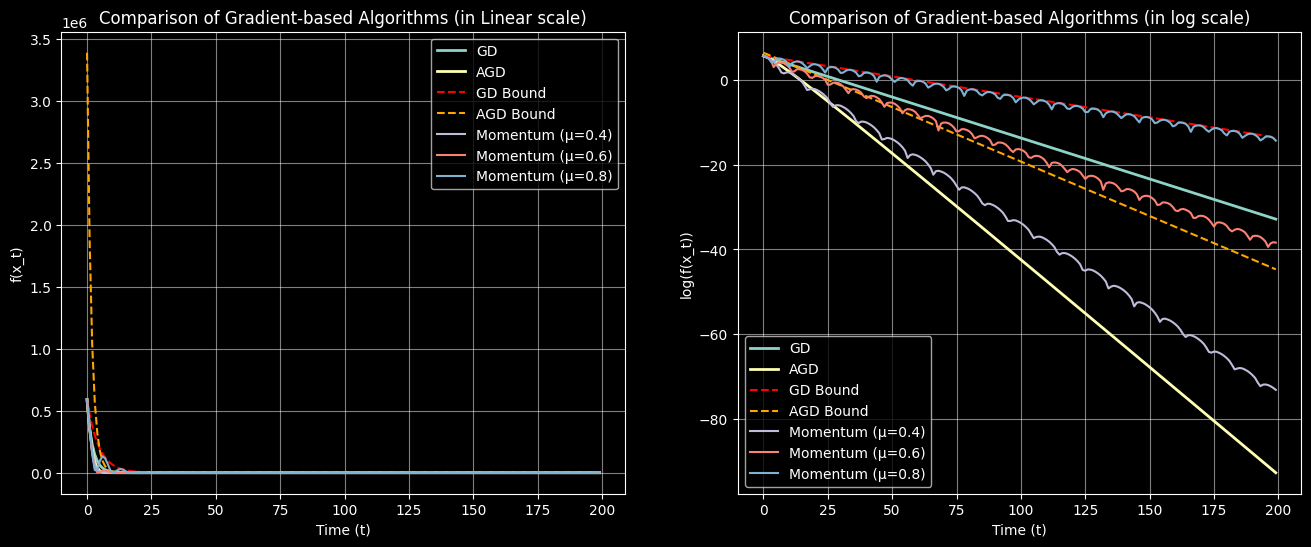

In [5]:
def plot_histories(history_gd, history_agd, history_momentum):
    t_range = np.arange(T)
    
    beta = float(max(1, K))
    alpha = float(min(1, K))
    cond_num = beta / alpha
    
    # Bound for Gradient Descent
    gamma_gd = alpha / (beta - alpha)
    bound_gd = (1 + gamma_gd)**(-t_range) * f(x0)
    
    # Bound for AGD
    x_opt = np.zeros(n)
    gamma_agd = 1.0 / (np.sqrt(cond_num) - 1)
    prefactor = (alpha + beta) / 2.0 * np.sum((x0 - x_opt)**2)
    bound_agd = (1 + gamma_agd)**(-t_range) * prefactor

    def power_formatter(value, _):
        return f"10^{value}"
    
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    for ax, is_log in zip([ax1, ax2], [False, True]):
        if is_log:
            history_gd = np.log10(np.array(history_gd))
            history_agd = np.log10(np.array(history_agd))
            bound_gd = np.log10(np.array(bound_gd))
            bound_agd = np.log10(np.array(bound_agd))
            
            history_momentum2 = {}
            for mu, history_m in history_momentum.items():
                history_momentum2[mu] = np.log10(np.array(history_m))
            history_momentum = history_momentum2
            ax.set_ylabel('log(f(x_t))')
            ax.set_title('Comparison of Gradient-based Algorithms (in log scale)')
        else:
            ax.set_ylabel('f(x_t)')
            ax.set_title('Comparison of Gradient-based Algorithms (in Linear scale)')

        ax.plot(t_range, history_gd, label='GD', linewidth=2)
        ax.plot(t_range, history_agd, label='AGD', linewidth=2)
        ax.plot(t_range, bound_gd, label='GD Bound', color='red', linestyle='--')
        ax.plot(t_range, bound_agd, label='AGD Bound', color='orange', linestyle='--')
        
        # Plot Momentum results for each mu
        for mu, history_m in history_momentum.items():
            ax.plot(t_range, history_m, label=f'Momentum (μ={mu})')
            
        ax.set_xlabel('Time (t)')
        ax.legend()
        ax.grid(True, which="both", ls="-", alpha=0.5)
    
    plt.show()

plot_histories(history_gd, history_agd, history_momentum)

## Results

From the above observations, we conclude the following facts:
1. All the algorithms are able to perfectly converges to the optimal solution $x^*$ within the defined iteration limit.
2. The accelerated gradient descent algorithm converges fastest to the optimal solution followed by momentum method with low values of $\mu$ followed by gradient descent and closing with the momentum method with higher values of $\mu$.

    Accelerated Gradient Descent > Momentum ($\mu = 0.4$ > Momentum ($\mu = 0.6$ > Gradient Descent > Momentum ($\mu = 0.8$
3. For $\kappa = 5$, both gradient descent and accelerated gradient descent stay well within the theoretical upper bound

## For $\kappa = 20$

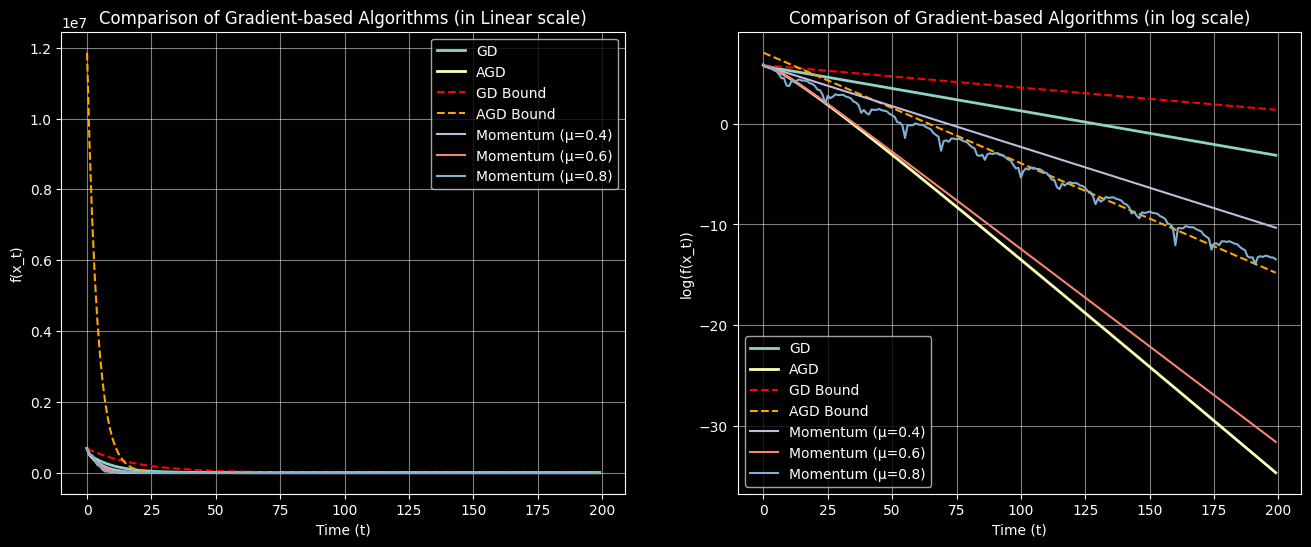

In [6]:
K = 20
L = float(max(1, K))
eta = 1.0 / L

history_gd = run_gd()
history_agd = run_agd()
history_momentum = run_momentum_method()

plot_histories(history_gd, history_agd, history_momentum)

### Results
From the above plots for $\kappa = 20$, we come to the following conclusions:
1. All the the algorithms are still able to perfectly converges to the optimal solution $x^*$ within the defined iteration limit.
2. However the order of convergence of the algorithms change in this case
    
   Accelerated Gradient Descent > Momentum ($\mu = 0.6$ > Momentum ($\mu = 0.8$ > Momentum ($\mu = 0.4$ > Gradient Descent
3. Both gradient descent and accelerated gradient descent still stay well within the theoretical upper bound.

## For $\kappa = 50$

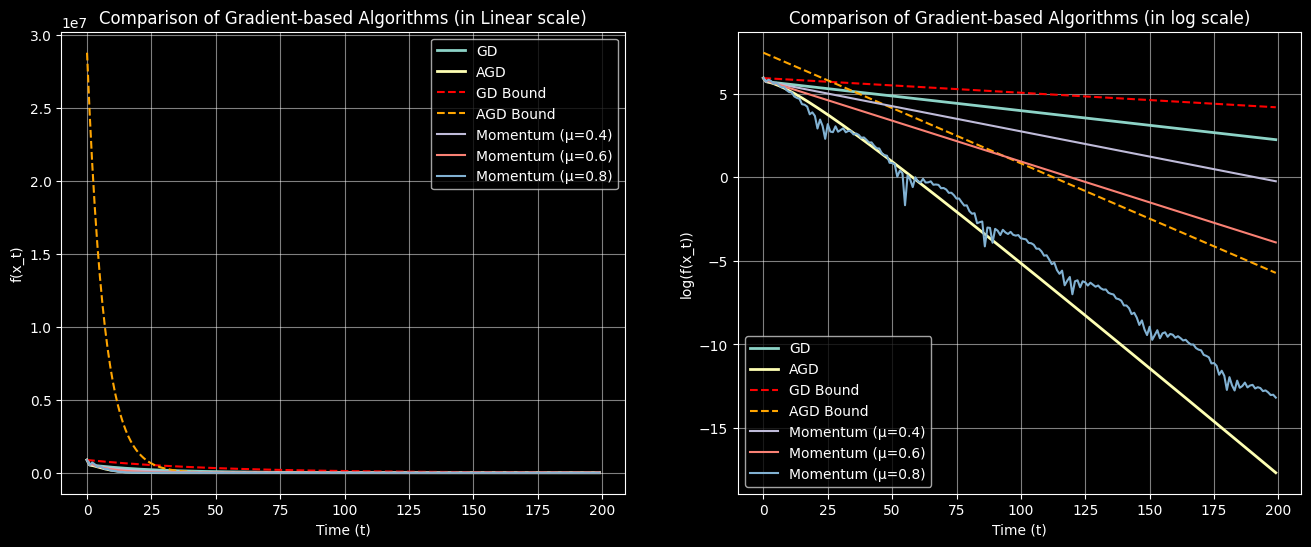

In [7]:
K = 50
L = float(max(1, K))
eta = 1.0 / L

history_gd = run_gd()
history_agd = run_agd()
history_momentum = run_momentum_method()

plot_histories(history_gd, history_agd, history_momentum)

### Results
From the above plots for $\kappa = 50$, we come to the following conclusions:
1. All the the algorithms are still able to perfectly converges to the optimal solution $x^*$ within the defined iteration limit.
2. The order of convergence of the algorithms again change in this case
    
   Accelerated Gradient Descent > Momentum ($\mu = 0.8$ > Momentum ($\mu = 0.6$ > Momentum ($\mu = 0.4$ > Gradient Descent
3. Both gradient descent and accelerated gradient descent still stay well within the theoretical upper bound.

## For $\eta = 2 / \beta$

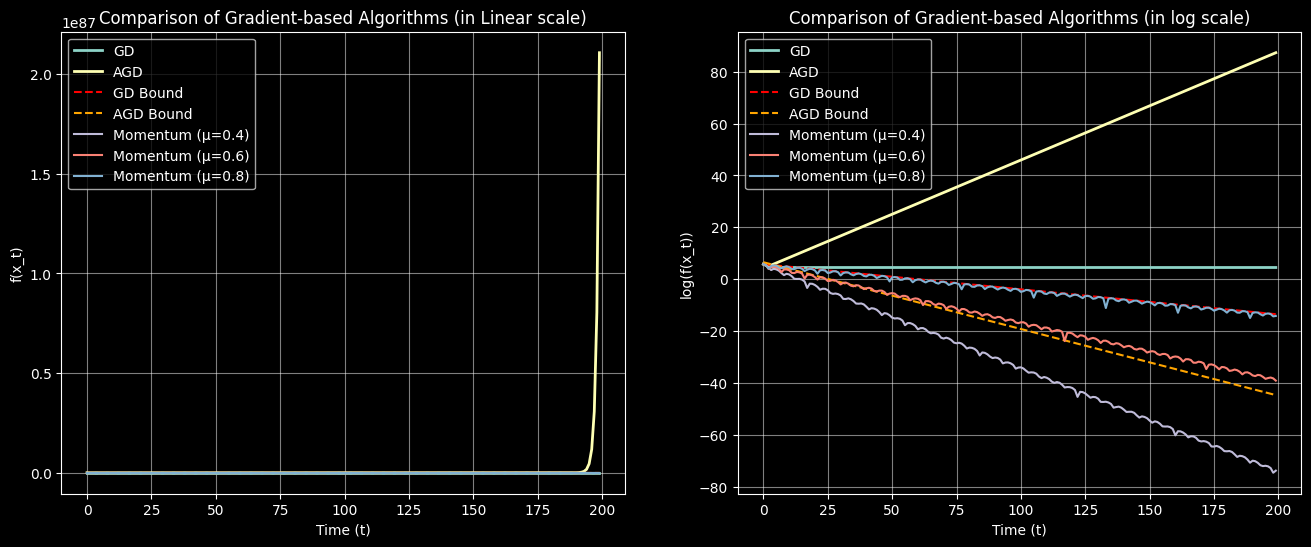

In [8]:
K = 5
L = float(max(1, K))
eta = 2 / L


history_gd = run_gd()
history_agd = run_agd()
history_momentum = run_momentum_method()

plot_histories(history_gd, history_agd, history_momentum)

### Results
From the above plots for $\eta = 2/\beta$, we come to the following conclusions:
1. All the the algorithms except **accelerated gradient descent** are able to perfectly converges to the optimal solution $x^*$ within the defined iteration limit.
2. However, both gradient descent and accelerated gradient descent exceed their theoretical upper bounds for all $x$ in the domain.
3. The accelerated gradient descent overshoot to $\infty$ towards the very end of the iterations

## Conclusion
1. The given function $f(x)$ has a optimal solution at $x = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}$.
2. The function is convex, smooth and strongly-convex with smoothness and strongly-convex parameters $\beta = \kappa$ and $\alpha = 1$.
3. For various values of $\kappa$, the function can be converged to its optimal solution by various algorithms like gradient descent, accelerated gradient descent and momentum method.
4. For $\eta = 2/\beta$, the accelerated gradient descent method fails to converge to the optimal solution.